In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)

# Описание данных

Дота 2 - многопользовательская онлайн игра, где игроки объединяются в команды по 5 человек и играют на карте с башнями и троном для каждой команды (Силы Света или Силы Тьмы), сторона выпадает рандомно. Игроки должны осаждать вражеские башни, убивая вражеских героев и оборонять свои постройки.

После смерти герои снова появляются на карте спустя 30-120 секунд в зависимости от их уровня. Игра заканчивается, когда одна из команд ломает вражеский трон (предварительно сломав все башни и другие постройки на карте, защищающие трон)

In [2]:
matches = pd.read_csv('matches_df_train.csv')
players = pd.read_csv('player_df.csv')
heroes = pd.read_csv('Constants.Heroes.csv')

matches.head()

,match_id,date,region,game_mode,duration,radiant_win
0,1606558457,2024-01-01,3,1,50,True
1,1533104773,2024-01-01,3,1,86,True
2,1494396881,2024-01-01,3,1,211,True
3,1457581060,2024-01-01,3,1,270,True
4,1590242915,2024-01-01,3,21,318,True


In [3]:
players.head()

,player_slot,account_id,hero_id,kills,deaths,assists,gold,last_hits,denies,gold_per_min,xp_per_min,hero_damage,tower_damage,match_id
0,130,10111871,5,3.0,8.0,15.0,2971.0,55.0,3.0,291.0,390.0,7431.0,146.0,1411590681
1,130,43341844,3,3.0,9.0,3.0,1245.0,25.0,3.0,238.0,346.0,4187.0,34.0,1388958799
2,130,72157343,53,9.0,6.0,20.0,4544.0,226.0,1.0,583.0,704.0,9406.0,2375.0,1587246664
3,1,4294967295,17,21.0,3.0,15.0,2945.0,209.0,12.0,577.0,641.0,30957.0,1801.0,1490278157
4,2,54350942,19,9.0,8.0,8.0,413.0,227.0,9.0,471.0,584.0,18215.0,627.0,1526223166


In [4]:
heroes.head()

,Unnamed: 0,id,name,primary_attr,attack_type,roles,img,icon,base_health,base_health_regen,base_mana,base_mana_regen,base_armor,base_mr,base_attack_min,base_attack_max,base_str,base_agi,base_int,str_gain,agi_gain,int_gain,attack_range,projectile_speed,attack_rate,base_attack_time,attack_point,move_speed,turn_rate,cm_enabled,legs,day_vision,night_vision,localized_name
0,0,1,npc_dota_hero_antimage,agi,Melee,"['Carry', 'Escape', 'Nuker']",/apps/dota2/images/dota_react/heroes/antimage....,/apps/dota2/images/dota_react/heroes/icons/ant...,120,1.00,75,0.0,1,25,29,33,19,24,12,1.6,2.8,1.8,150,0,1.4,100,0.30,310,NaN,True,2,1800,800,Anti-Mage
1,1,2,npc_dota_hero_axe,str,Melee,"['Initiator', 'Durable', 'Disabler', 'Carry']",/apps/dota2/images/dota_react/heroes/axe.png?,/apps/dota2/images/dota_react/heroes/icons/axe...,120,2.50,75,0.0,0,25,30,34,25,20,18,2.8,1.7,1.6,150,900,1.7,100,0.40,315,NaN,True,2,1800,800,Axe
2,2,3,npc_dota_hero_bane,all,Ranged,"['Support', 'Disabler', 'Nuker', 'Durable']",/apps/dota2/images/dota_react/heroes/bane.png?,/apps/dota2/images/dota_react/heroes/icons/ban...,120,0.25,75,0.0,1,25,-1,5,23,23,23,2.7,2.7,2.7,400,900,1.7,100,0.30,305,NaN,True,4,1800,1200,Bane
3,3,4,npc_dota_hero_bloodseeker,agi,Melee,"['Carry', 'Disabler', 'Nuker', 'Initiator']",/apps/dota2/images/dota_react/heroes/bloodseek...,/apps/dota2/images/dota_react/heroes/icons/blo...,120,0.25,75,0.0,2,25,35,41,24,24,17,2.7,3.1,2.0,150,900,1.7,100,0.43,285,NaN,True,2,1800,800,Bloodseeker
4,4,5,npc_dota_hero_crystal_maiden,int,Ranged,"['Support', 'Disabler', 'Nuker']",/apps/dota2/images/dota_react/heroes/crystal_m...,/apps/dota2/images/dota_react/heroes/icons/cry...,120,0.25,75,0.0,0,25,30,36,17,16,18,2.2,1.8,3.3,600,900,1.7,100,0.45,280,NaN,True,2,1800,800,Crystal Maiden


Для начала удалим ненужные столбцы из таблиц:

В таблице matches нам никак не поможет код региона и game mode
В таблице players нужно убрать last_hits, denies, gold_per_min, xp_per_min, hero_damage, tower_damage
В таблице heroes нужно оставить только столбцы: pimary_attr, attack_type, roles, localizzed_name

In [5]:
matches = matches[[
    'match_id',
    'date', 
    'duration', 
    'radiant_win'
]]

players = players[[
    'match_id',
    'account_id',
    'player_slot',      # нужен для определения команды (0-4 Radiant, 128-132 Dire)
    'hero_id',
    'kills',
    'deaths',
    'assists',
    'gold'
]]

heroes = heroes[[
    'id', 
    'localized_name',
    'primary_attr',
    'attack_type',
    'roles'
]].rename(columns={'id': 'hero_id'})

In [6]:
players_inf = pd.read_csv('player_df.csv')
players_inf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7650825 entries, 0 to 7650824
Data columns (total 14 columns):
 #   Column        Dtype  
---  ------        -----  
 0   player_slot   int64  
 1   account_id    int64  
 2   hero_id       int64  
 3   kills         float64
 4   deaths        float64
 5   assists       float64
 6   gold          float64
 7   last_hits     float64
 8   denies        float64
 9   gold_per_min  float64
 10  xp_per_min    float64
 11  hero_damage   float64
 12  tower_damage  float64
 13  match_id      int64  
dtypes: float64(10), int64(4)
memory usage: 817.2 MB


In [7]:
players = players.merge(heroes, on='hero_id', how='left')
players.head()

,match_id,account_id,player_slot,hero_id,kills,deaths,assists,gold,localized_name,primary_attr,attack_type,roles
0,1411590681,10111871,130,5,3.0,8.0,15.0,2971.0,Crystal Maiden,int,Ranged,"['Support', 'Disabler', 'Nuker']"
1,1388958799,43341844,130,3,3.0,9.0,3.0,1245.0,Bane,all,Ranged,"['Support', 'Disabler', 'Nuker', 'Durable']"
2,1587246664,72157343,130,53,9.0,6.0,20.0,4544.0,Nature's Prophet,int,Ranged,"['Carry', 'Pusher', 'Escape', 'Nuker']"
3,1490278157,4294967295,1,17,21.0,3.0,15.0,2945.0,Storm Spirit,int,Ranged,"['Carry', 'Escape', 'Nuker', 'Initiator', 'Dis..."
4,1526223166,54350942,2,19,9.0,8.0,8.0,413.0,Tiny,str,Melee,"['Carry', 'Nuker', 'Pusher', 'Initiator', 'Dur..."


In [8]:
players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7650825 entries, 0 to 7650824
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   match_id        int64  
 1   account_id      int64  
 2   player_slot     int64  
 3   hero_id         int64  
 4   kills           float64
 5   deaths          float64
 6   assists         float64
 7   gold            float64
 8   localized_name  object 
 9   primary_attr    object 
 10  attack_type     object 
 11  roles           object 
dtypes: float64(4), int64(4), object(4)
memory usage: 758.8+ MB


In [9]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 706880 entries, 0 to 706879
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   match_id     706880 non-null  int64 
 1   date         706880 non-null  object
 2   duration     706880 non-null  int64 
 3   radiant_win  706880 non-null  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 16.9+ MB


In [10]:
df = players.merge(matches, on='match_id', how='left')
df.head()

,match_id,account_id,player_slot,hero_id,kills,deaths,assists,gold,localized_name,primary_attr,attack_type,roles,date,duration,radiant_win
0,1411590681,10111871,130,5,3.0,8.0,15.0,2971.0,Crystal Maiden,int,Ranged,"['Support', 'Disabler', 'Nuker']",2024-08-09,2418.0,False
1,1388958799,43341844,130,3,3.0,9.0,3.0,1245.0,Bane,all,Ranged,"['Support', 'Disabler', 'Nuker', 'Durable']",2024-04-24,1971.0,True
2,1587246664,72157343,130,53,9.0,6.0,20.0,4544.0,Nature's Prophet,int,Ranged,"['Carry', 'Pusher', 'Escape', 'Nuker']",2024-06-23,2581.0,False
3,1490278157,4294967295,1,17,21.0,3.0,15.0,2945.0,Storm Spirit,int,Ranged,"['Carry', 'Escape', 'Nuker', 'Initiator', 'Dis...",2024-11-29,3038.0,True
4,1526223166,54350942,2,19,9.0,8.0,8.0,413.0,Tiny,str,Melee,"['Carry', 'Nuker', 'Pusher', 'Initiator', 'Dur...",2024-11-15,2802.0,False


In [11]:
df['team'] = (df['player_slot'] >= 128).map({False: 'radiant', True: 'dire'})

Данные представлены в нескольких таблицах формата .csv

**matches (данные о матчах)**

- match_id (идентификатор матча)
- date
- region
- gamemode
- duration
- radiant_win

**players (данные о героях)**

- match_id (идентификатор матча)
- player_slot (слот игрока)
- assists (помощь в убийстве другим игрокам)
- deaths (летальные исходы игрока)
- denies (кол-во денаев, полученных игроком во время матча)
- gold_per_min (золото в минуту)
- hero_id идентификатор героя
- item_0, item_1, item_2, item_3, item_4, item_5 (оружие героя)
- kills (кол-во убийств, совершенных игроком)
- xp_per_min опыт в минуту
- isRadiant (команда: True-свет; Folse-тьма)
- win результат матча(1-победа, 0-поражение)



**Исследовательский вопрос**

Возможно ли предсказать исход матча до его начала на исторических данных с помощью модели машинного обучения

Очевидно, что по статистике матча: перевес голды, опыта, продолжительности можно предсказать, какая команда сильнее и какая команда победит, но возможно ли сделать это до начала матча, когда нам известны только игроки, герои и исторические данные.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7650925 entries, 0 to 7650924
Data columns (total 16 columns):
 #   Column          Dtype  
---  ------          -----  
 0   match_id        int64  
 1   account_id      int64  
 2   player_slot     int64  
 3   hero_id         int64  
 4   kills           float64
 5   deaths          float64
 6   assists         float64
 7   gold            float64
 8   localized_name  object 
 9   primary_attr    object 
 10  attack_type     object 
 11  roles           object 
 12  date            object 
 13  duration        float64
 14  radiant_win     object 
 15  team            object 
dtypes: float64(5), int64(4), object(7)
memory usage: 992.3+ MB


# Исследовательский анализ данных

По задумке в датасете каждая строка должна показывать конкретного игрока в конкретном матче. Посмотрим число уникальных игроков и число уникальных матчей.

In [13]:
print(f"Всего игроков: {df['account_id'].nunique():,}")
print(f"Всего уникальных матчей: {df['match_id'].nunique():,}")
print(f"Игроков на матч: {len(df) / df['match_id'].nunique():.1f} (должно быть ~10)\n")

Всего игроков: 974,931
Всего уникальных матчей: 767,822
Игроков на матч: 10.0 (должно быть ~10)



## Анализ выбросов

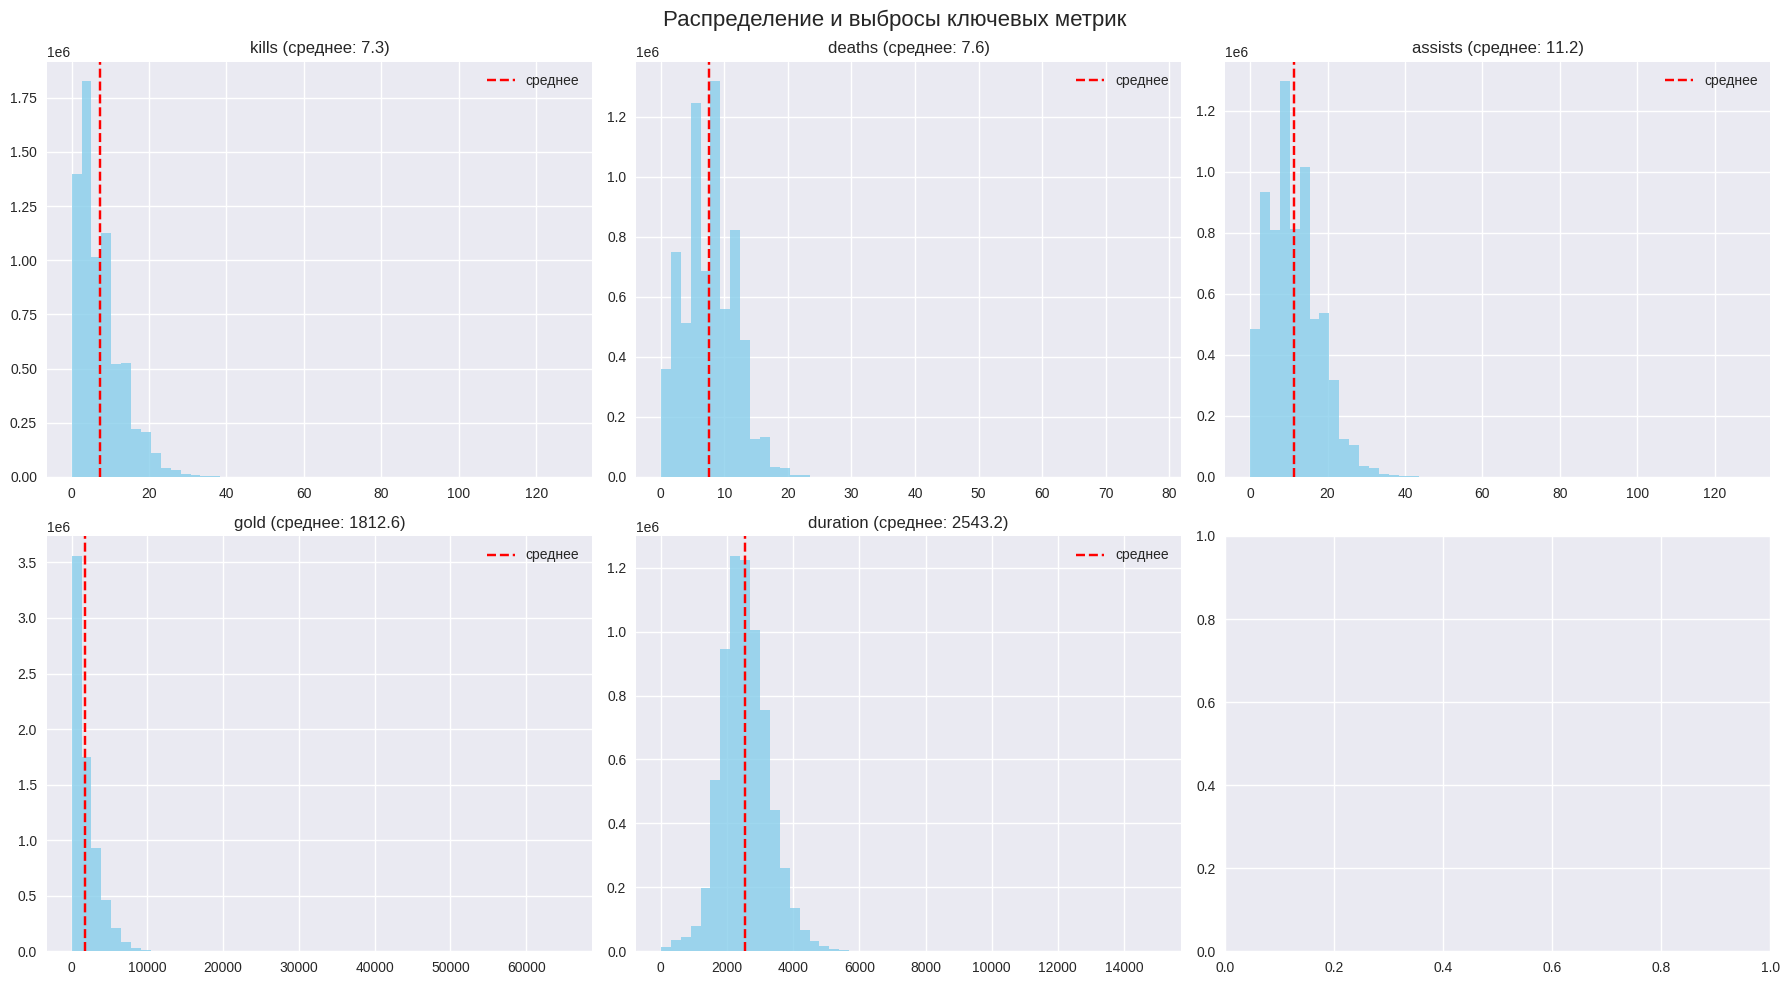

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Распределение и выбросы ключевых метрик', fontsize=16)

cols = ['kills', 'deaths', 'assists', 'gold', 'duration']
for i, col in enumerate(cols):
    ax = axes[i//3, i%3]
    df[col].hist(bins=50, ax=ax, color='skyblue', alpha=0.8)
    ax.set_title(f'{col} (среднее: {df[col].mean():.1f})')
    ax.axvline(df[col].mean(), color='red', linestyle='--', label='среднее')
    ax.legend()

plt.tight_layout()
plt.show()

## Анализ пропусков

In [15]:
df.isna().sum()

match_id               0
account_id             0
player_slot            0
hero_id                0
kills             607504
deaths            607504
assists           607504
gold              607504
localized_name      3615
primary_attr        3615
attack_type         3615
roles               3615
date              607494
duration          607494
radiant_win       607494
team                   0
dtype: int64

In [16]:
print(f"Всего строк: {len(df):,}")
ghost_players = df[df['duration'].isna()]
print(f"Строк-призраков (нет данных о матче): {len(ghost_players):,}")
ghost_matches = df[df['kills'].isna() & df['deaths'].isna() & df['assists'].isna()]
print(f"Матчей без игроков: {len(ghost_matches):,}")
real_rows = df[df['duration'].notna() & df['kills'].notna()]
print(f"Реальных строк (игрок + матч): {len(real_rows):,}")

Всего строк: 7,650,925
Строк-призраков (нет данных о матче): 607,494
Матчей без игроков: 607,504
Реальных строк (игрок + матч): 7,043,411


In [17]:
df = df.dropna(subset=['match_id', 'duration', 'radiant_win', 'kills', 'deaths', 'assists', 'localized_name'])

print(f"После очистки: {len(df):,} строк")
print(df.isna().sum()[df.isna().sum() > 0])

После очистки: 7,040,065 строк
Series([], dtype: int64)


## Вопросы анализа

In [18]:
df['team'] = np.where(df['player_slot'] < 128, 'radiant', 'dire')
df['player_win'] = np.where(
    (df['team'] == 'radiant') & (df['radiant_win'] == True) |
    (df['team'] == 'dire') & (df['radiant_win'] == False),
    True, False
)

### Какая команда побеждает чаще?

In [19]:
winrate_rad = df.groupby('match_id')['radiant_win'].first().mean()
print(f"Radiant (Свет) побеждает в {winrate_rad:.2%} матчей")
print(f"Dire (Тьма) побеждает в {(1-winrate_rad):.2%}")

Radiant (Свет) побеждает в 51.25% матчей
Dire (Тьма) побеждает в 48.75%


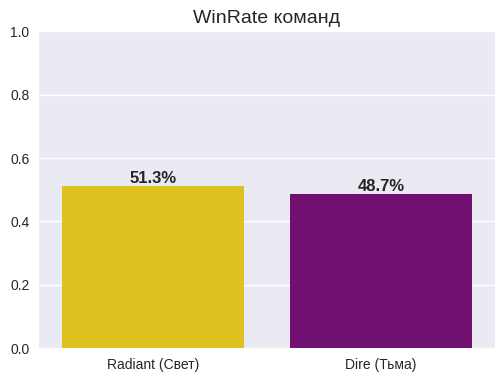

In [20]:
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3)
ax1 = fig.add_subplot(gs[0, 0])
sns.barplot(x=['Radiant (Свет)', 'Dire (Тьма)'], y=[winrate_rad, 1-winrate_rad], palette=['gold', 'purple'], ax=ax1)
ax1.set_title('WinRate команд', fontsize=14)
ax1.set_ylim(0, 1)
for i, v in enumerate([winrate_rad, 1-winrate_rad]):
    ax1.text(i, v + 0.01, f'{v:.1%}', ha='center', fontweight='bold', fontsize=12)

### Самые популярные и непопулярные герои

In [21]:
top_hero = df['localized_name'].value_counts().head(1)
print(f"\n Самый популярный герой: {top_hero.index[0]} — выбран {top_hero.iloc[0]:,} раз")


 Самый популярный герой: Pudge — выбран 161,673 раз


![](https://cdn1.ozone.ru/s3/multimedia-9/c600/6147686265.jpg)

Text(0.5, 1.0, 'Топ-10 самых популярных героев')

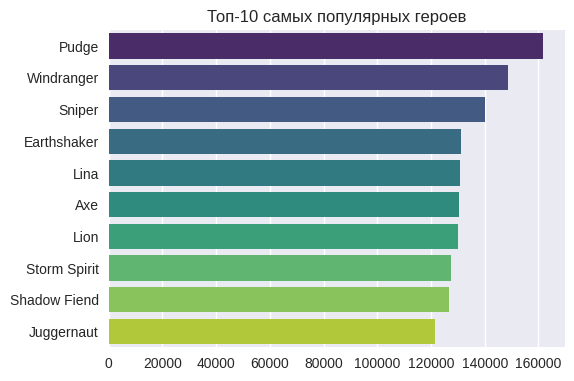

In [22]:
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3)
ax2 = fig.add_subplot(gs[0, 1])
top10 = df['localized_name'].value_counts().head(10)
sns.barplot(y=top10.index, x=top10.values, palette='viridis', ax=ax2)
ax2.set_title('Топ-10 самых популярных героев')

In [23]:
atop_hero = df['localized_name'].value_counts().tail(1)
print(f"\n Самый непопулярный герой: {atop_hero.index[0]} — выбран {atop_hero.iloc[0]:,} раз")


 Самый непопулярный герой: Chen — выбран 16,467 раз


![](https://avatars.mds.yandex.net/i?id=11060e9eacc18f5f7cc8be561906b2e8_l-7570837-images-thumbs&n=13)

Text(0.5, 1.0, 'Топ-10 самых непопулярных героев')

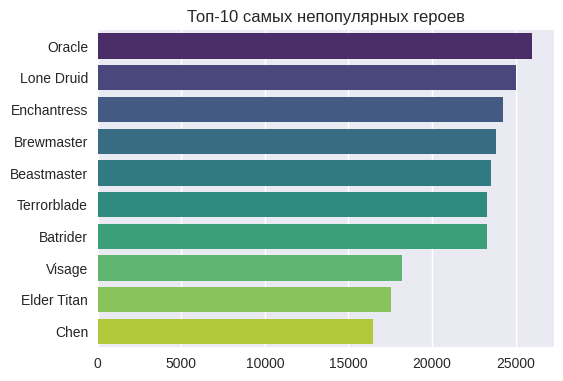

In [24]:
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3)
ax2 = fig.add_subplot(gs[0, 1])
atop10 = df['localized_name'].value_counts().tail(10)
sns.barplot(y=atop10.index, x=atop10.values, palette='viridis', ax=ax2)
ax2.set_title('Топ-10 самых непопулярных героев')

### Герои с наибольшей и наименьшей долей побед

In [25]:
hero_winrate = df.groupby('localized_name')['player_win'].mean().sort_values(ascending=False)
print(f"Герой с наибольшим винрейтом: {hero_winrate.index[0]} — {hero_winrate.iloc[0]:.2%} побед")

Герой с наибольшим винрейтом: Undying — 58.51% побед


Text(0.5, 1.0, 'Топ-10 героев по винрейту')

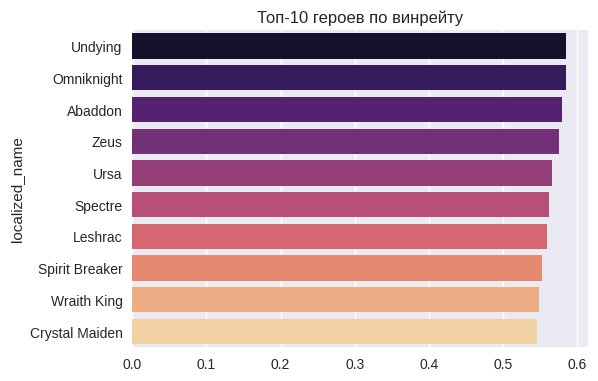

In [26]:
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3)
ax3 = fig.add_subplot(gs[0, 2])
top_wr = hero_winrate.head(10)
sns.barplot(y=top_wr.index, x=top_wr.values, palette='magma', ax=ax3)
ax3.set_title('Топ-10 героев по винрейту')

In [27]:
hero_loserate = df.groupby('localized_name')['player_win'].mean().sort_values(ascending=True)
print(f"Герой с наименьшим винрейтом: {hero_winrate.index[0]} — {hero_winrate.iloc[0]:.2%} побед")

Герой с наименьшим винрейтом: Undying — 58.51% побед


Text(0.5, 1.0, 'АнтиТоп-10 героев по винрейту')

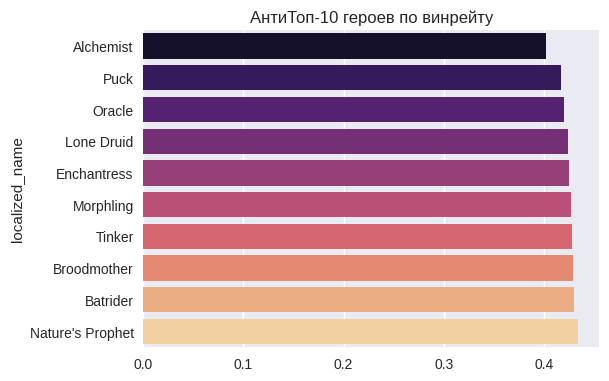

In [28]:
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3)
ax3 = fig.add_subplot(gs[0, 2])
atop_wr = hero_loserate.head(10)
sns.barplot(y=atop_wr.index, x=atop_wr.values, palette='magma', ax=ax3)
ax3.set_title('АнтиТоп-10 героев по винрейту')

Можем заметить, что герой влияет на победу в игре

### Распределение длительностей матчей

In [29]:
avg_duration = df['duration'].mean() / 60
print(f"\n7. Средняя длительность матча: {avg_duration:.2f} минут")


7. Средняя длительность матча: 42.39 минут


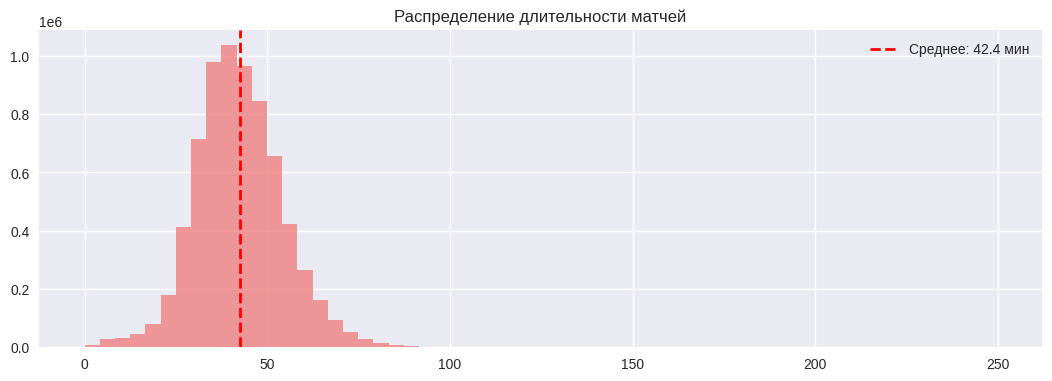

In [30]:
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3)
ax7 = fig.add_subplot(gs[2, :2])
df['duration_min'] = df['duration'] / 60
df['duration_min'].hist(bins=60, ax=ax7, color='lightcoral', alpha=0.8)
ax7.axvline(avg_duration, color='red', linestyle='--', linewidth=2, label=f'Среднее: {avg_duration:.1f} мин')
ax7.set_title('Распределение длительности матчей')
ax7.legend()

## Создание новых признаков

In [31]:
df.head()

,match_id,account_id,player_slot,hero_id,kills,deaths,assists,gold,localized_name,primary_attr,attack_type,roles,date,duration,radiant_win,team,player_win,duration_min
0,1411590681,10111871,130,5,3.0,8.0,15.0,2971.0,Crystal Maiden,int,Ranged,"['Support', 'Disabler', 'Nuker']",2024-08-09,2418.0,False,dire,True,40.300000
1,1388958799,43341844,130,3,3.0,9.0,3.0,1245.0,Bane,all,Ranged,"['Support', 'Disabler', 'Nuker', 'Durable']",2024-04-24,1971.0,True,dire,False,32.850000
2,1587246664,72157343,130,53,9.0,6.0,20.0,4544.0,Nature's Prophet,int,Ranged,"['Carry', 'Pusher', 'Escape', 'Nuker']",2024-06-23,2581.0,False,dire,True,43.016667
3,1490278157,4294967295,1,17,21.0,3.0,15.0,2945.0,Storm Spirit,int,Ranged,"['Carry', 'Escape', 'Nuker', 'Initiator', 'Dis...",2024-11-29,3038.0,True,radiant,True,50.633333
4,1526223166,54350942,2,19,9.0,8.0,8.0,413.0,Tiny,str,Melee,"['Carry', 'Nuker', 'Pusher', 'Initiator', 'Dur...",2024-11-15,2802.0,False,radiant,False,46.700000


Для эффективного предсказания исхода матча мы хотим узнать винрейт каждого героя за год - может быть, какие-то герои практически гарантируют победу или поражение

Мы также хотим узнать винрейт каждого игрока на каждом герое за год. То есть, например, если игрок регулярно хорошо играет на конкретном герое: он скорее всего хорошо сыграет и в этой игре тоже

Кроме того, сущетсвуют связки: возможно, какие-то герои неэффективны по одному, но эффективны в паре. Посмотрим винрейт для всех пар героев

Также стоит подумать о контр-пиках: может быть, если одна команда пикнула героя А, а другая героя Б, герой А имеет винрейт около 20% именно против героя Б

Сила некоторых героев зависит от того, играют они против определенного героя или нет. То есть, если в разных командах находятся определенные герои А и Б, то можно предсказать исход игры, если герой А контр-пик героя Б

In [32]:
df['team'] = np.where(df['player_slot'] < 128, 'radiant', 'dire')
df['player_win'] = np.where(
    (df['team'] == 'radiant') & df['radiant_win'],
    True,
    (df['team'] == 'dire') & ~df['radiant_win']
)

### Признак "сильная связка"

![](https://avatars.mds.yandex.net/i?id=af65b89edd5f644e8de59bf1897a6322_l-5333776-images-thumbs&n=13)

In [33]:
df = df.convert_dtypes()
df['localized_name'] = df['localized_name'].astype(str)
df['team_id'] = (df['player_slot'] >= 128).astype(int)

df['outcome'] = (
    ((df['team_id'] == 0) & (df['radiant_win'] == True)) | 
    ((df['team_id'] == 1) & (df['radiant_win'] == False))
)

cols = ['match_id', 'team_id', 'localized_name', 'outcome']
df_minimal = df[cols]

pairs_df = df_minimal.merge(
    df_minimal, 
    on=['match_id', 'team_id']
)

pairs_df = pairs_df[pairs_df['localized_name_x'] < pairs_df['localized_name_y']]

pair_stats = pairs_df.groupby(['localized_name_x', 'localized_name_y'])['outcome_x'].agg(
    g='count', 
    w='sum'
).reset_index()


pair_stats['wr'] = pair_stats['w'] / pair_stats['g']
pair_stats.rename(columns={'localized_name_x': 'h1', 'localized_name_y': 'h2'}, inplace=True)
strong_pairs_df = pair_stats[(pair_stats['g'] >= 15) & (pair_stats['wr'] > 0.60)]
strong_set = set(zip(strong_pairs_df['h1'], strong_pairs_df['h2']))

print(f"Found {len(strong_set)} strong pairs.")
print(strong_pairs_df.head())

Found 167 strong pairs.
         h1                 h2     g     w        wr
7   Abaddon        Bloodseeker  2956  1872  0.633288
12  Abaddon  Centaur Warrunner  1291   805  0.623548
17  Abaddon     Crystal Maiden  2882  1799  0.624219
19  Abaddon             Dazzle  1713  1080  0.630473
21  Abaddon          Disruptor  1506   917  0.608898


### Признак "Контр-пик" (1,0,-1)

In [34]:
cols = ['match_id', 'localized_name']
rad_df = df[df['player_slot'] < 128][cols + ['radiant_win']]
dire_df = df[df['player_slot'] >= 128][cols]
matches_joined = rad_df.merge(
    dire_df, 
    on='match_id', 
    suffixes=('_a', '_b') 
)
matches_joined = matches_joined[
    matches_joined['localized_name_a'] != matches_joined['localized_name_b']
]

c_stats = matches_joined.groupby(['localized_name_a', 'localized_name_b'])['radiant_win'].agg(
    g='count',
    w='sum'
).reset_index()

c_stats['wr'] = c_stats['w'] / c_stats['g']
c_stats = c_stats[c_stats['g'] >= 12]

strong_df = c_stats[c_stats['wr'] > 0.60]
weak_df   = c_stats[c_stats['wr'] < 0.40]

strong_c = set(zip(strong_df['localized_name_a'], strong_df['localized_name_b']))
weak_c   = set(zip(weak_df['localized_name_a'],   weak_df['localized_name_b']))

print(f"Strong counters found: {len(strong_c)}")
print(f"Weak counters found: {len(weak_c)}")
display(c_stats.sort_values('wr', ascending=False).head())

Strong counters found: 860
Weak counters found: 370


,localized_name_a,localized_name_b,g,w,wr
29,Abaddon,Enchantress,467,337,0.721627
6650,Omniknight,Alchemist,947,680,0.718057
10627,Undying,Morphling,893,634,0.709966
6715,Omniknight,Puck,873,619,0.709049
10574,Undying,Alchemist,1360,957,0.703676


### Признак "Мастер своего героя" (винрейт игрока на герое)

![](https://images.steamusercontent.com/ugc/10604735945510424540/A4BBF1315E78ABF2348E804F3317820A8E8BBDA6/)

In [35]:
if df['localized_name'].dtype == 'object':
    df['localized_name'] = df['localized_name'].astype('category')

grouper = df.groupby(['account_id', 'localized_name'])['outcome']

counts = grouper.transform('count')
means = grouper.transform('mean')

df['master'] = np.where(
    (counts >= 5) & (means > 0.60),
    1,
    0
)

print(f"Мастеров: {(df['master'] == 1).sum():,} из {len(df):,}")

Мастеров: 216,727 из 7,040,065


### Признак "Метовый винрейт" (винрейт героя за последние 30 дней (мета))

In [36]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['localized_name', 'date']).reset_index(drop=True)

stats = (
    df.set_index('date')
    .groupby('localized_name')['outcome']
    .rolling('30D', closed='right')
    .agg(['count', 'sum'])
    .reset_index()
)

df['games_last_30d'] = stats['count']
df['wins_last_30d']  = stats['sum']
df['meta_winrate'] = np.where(
    df['games_last_30d'] >= 30,
    df['wins_last_30d'] / df['games_last_30d'],
    np.nan
)

overall_meta = df.groupby('localized_name')['outcome'].transform('mean')
df['meta_winrate'] = df['meta_winrate'].fillna(overall_meta)

df = df.drop(columns=['games_last_30d', 'wins_last_30d'])

### Заполняем новые признаки

In [37]:
def calculate_synergies_vectorized(df, strong_set, strong_c, weak_c):
    df_pair_lookup = pd.DataFrame(list(strong_set), columns=['h1', 'h2'])
    df_pair_lookup['is_pair'] = 1
    
    df_strong_c = pd.DataFrame(list(strong_c), columns=['hero', 'enemy'])
    df_strong_c['is_strong'] = 1
    
    df_weak_c = pd.DataFrame(list(weak_c), columns=['hero', 'enemy'])
    df_weak_c['is_weak'] = 1

    df['team_id'] = (df['player_slot'] >= 128).astype(int)
    
    cols = ['match_id', 'team_id', 'localized_name']
    teammates = df[cols].merge(df[cols], on=['match_id', 'team_id'])
    teammates = teammates[teammates['localized_name_x'] != teammates['localized_name_y']]
    name_x = teammates['localized_name_x'].astype(str)
    name_y = teammates['localized_name_y'].astype(str)
    
    mask = name_x < name_y
    teammates['h1'] = np.where(mask, name_x, name_y)
    teammates['h2'] = np.where(mask, name_y, name_x)
    teammates = teammates.merge(df_pair_lookup, on=['h1', 'h2'], how='left')
    
    pair_scores = teammates.groupby(['match_id', 'localized_name_x'])['is_pair'].max().fillna(0).reset_index()
    pair_scores.rename(columns={'localized_name_x': 'localized_name', 'is_pair': 'pair'}, inplace=True)

    rad_cols = df[df['team_id'] == 0][['match_id', 'localized_name']]
    dire_cols = df[df['team_id'] == 1][['match_id', 'localized_name']]
    rad_cols['localized_name'] = rad_cols['localized_name'].astype(str)
    dire_cols['localized_name'] = dire_cols['localized_name'].astype(str)
    
    timestamps = rad_cols.merge(dire_cols, on='match_id', suffixes=('_rad', '_dire'))
    p1 = timestamps.rename(columns={'localized_name_rad': 'hero', 'localized_name_dire': 'enemy'})
    p2 = timestamps.rename(columns={'localized_name_dire': 'hero', 'localized_name_rad': 'enemy'})
    
    all_matchups = pd.concat([p1, p2], ignore_index=True)
    
    all_matchups = all_matchups.merge(df_strong_c, on=['hero', 'enemy'], how='left')
    all_matchups = all_matchups.merge(df_weak_c, on=['hero', 'enemy'], how='left')
    
    contr_stats = all_matchups.groupby(['match_id', 'hero'])[['is_strong', 'is_weak']].max().reset_index()
    
    contr_stats['contr'] = np.select(
        [contr_stats['is_strong'] == 1, contr_stats['is_weak'] == 1],
        [1, -1],
        default=0
    )
    contr_stats.rename(columns={'hero': 'localized_name'}, inplace=True)
    df['localized_name_str'] = df['localized_name'].astype(str)
    
    df = df.merge(pair_scores, 
                  left_on=['match_id', 'localized_name_str'], 
                  right_on=['match_id', 'localized_name'], 
                  how='left', suffixes=('', '_drop'))
    
    df = df.merge(contr_stats[['match_id', 'localized_name', 'contr']], 
                  left_on=['match_id', 'localized_name_str'], 
                  right_on=['match_id', 'localized_name'], 
                  how='left', suffixes=('', '_y'))
    
    df[['pair', 'contr']] = df[['pair', 'contr']].fillna(0).astype(int)
    
    cols_to_drop = ['localized_name_str', 'localized_name_drop', 'localized_name_y', 'team_id', 'player_win']
    df.drop(columns=[c for c in cols_to_drop if c in df.columns], inplace=True)
    
    return df

df = calculate_synergies_vectorized(df, strong_set, strong_c, weak_c)


In [38]:
df.head()

,match_id,account_id,player_slot,hero_id,kills,deaths,assists,gold,localized_name,primary_attr,attack_type,roles,date,duration,radiant_win,team,duration_min,outcome,master,meta_winrate,pair,contr
0,1610077142,78558583,2,102,6,9,16,1331,Abaddon,all,Melee,"['Support', 'Carry', 'Durable']",2024-01-01,1812,True,radiant,30.2,True,0,0.579268,1,1
1,1574546205,4294967295,1,102,8,2,7,5146,Abaddon,all,Melee,"['Support', 'Carry', 'Durable']",2024-01-01,1863,True,radiant,31.05,True,0,0.579268,1,1
2,1361130621,4294967295,2,102,4,3,15,1764,Abaddon,all,Melee,"['Support', 'Carry', 'Durable']",2024-01-01,3042,True,radiant,50.7,True,0,0.579268,1,1
3,1621277760,56859698,3,102,1,2,6,934,Abaddon,all,Melee,"['Support', 'Carry', 'Durable']",2024-01-01,2098,True,radiant,34.966667,True,0,0.579268,1,1
4,1283098308,4294967295,4,102,7,4,20,3981,Abaddon,all,Melee,"['Support', 'Carry', 'Durable']",2024-01-01,2351,True,radiant,39.183333,True,0,0.579268,1,1


In [39]:
agg_features = {
    'master': ('master', 'sum'),
    'meta_winrate': ('meta_winrate', 'mean'),
    'pair': ('pair', 'sum'),
    'contr': ('contr', 'sum'),
}

team_features = df.groupby(['match_id', 'team']).agg(**agg_features).reset_index()

wide = team_features.pivot(
    index='match_id',
    columns='team',
    values=['master', 'meta_winrate', 'pair', 'contr']
)

wide.columns = [f"{feat}_{team}" for feat, team in wide.columns]
wide = wide.reset_index()
wide['pair_radiant'] = wide['pair_radiant'] / 2
wide['pair_dire']    = wide['pair_dire']    / 2

target = df[['match_id', 'radiant_win']].drop_duplicates()

final_df = wide.merge(target, on='match_id', how='left')

final_df['master_diff']      = final_df['master_radiant'] - final_df['master_dire']
final_df['meta_diff']        = final_df['meta_winrate_radiant'] - final_df['meta_winrate_dire']
final_df['pair_diff']        = final_df['pair_radiant'] - final_df['pair_dire']
final_df['contr_diff']       = final_df['contr_radiant'] - final_df['contr_dire']

print(final_df.columns.tolist())
display(final_df.head(3))

['match_id', 'master_dire', 'master_radiant', 'meta_winrate_dire', 'meta_winrate_radiant', 'pair_dire', 'pair_radiant', 'contr_dire', 'contr_radiant', 'radiant_win', 'master_diff', 'meta_diff', 'pair_diff', 'contr_diff']


,match_id,master_dire,master_radiant,meta_winrate_dire,meta_winrate_radiant,pair_dire,pair_radiant,contr_dire,contr_radiant,radiant_win,master_diff,meta_diff,pair_diff,contr_diff
0,245413525,0.0,0.0,0.481490,0.465531,0.0,0.0,1.0,0.0,False,0.0,-0.015960,0.0,-1.0
1,271145478,3.0,1.0,0.466274,0.459116,0.0,0.0,-1.0,-1.0,False,-2.0,-0.007158,0.0,0.0
2,610497965,0.0,0.0,0.485587,0.479999,0.0,0.0,-1.0,0.0,True,0.0,-0.005587,0.0,1.0


In [40]:
final_df = final_df[['match_id', 'radiant_win', 'master_diff', 'meta_diff', 'pair_diff', 'contr_diff']]
final_df = final_df.dropna()
final_df.head()

,match_id,radiant_win,master_diff,meta_diff,pair_diff,contr_diff
0,245413525,False,0.0,-0.015960,0.0,-1.0
1,271145478,False,-2.0,-0.007158,0.0,0.0
2,610497965,True,0.0,-0.005587,0.0,1.0
3,613258812,True,1.0,-0.003092,0.0,-2.0
4,639442405,False,-1.0,0.019828,0.0,2.0


# Обучение моделей

## Бейзлайны

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [42]:
X = final_df[['master_diff', 'meta_diff', 'pair_diff', 'contr_diff']]
y = final_df['radiant_win'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
                                                    
results = []

### Логистическая регрессия

In [43]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)
acc_lr = accuracy_score(y_test, pred_lr)
results.append(('Logistic Regression', acc_lr))
print('Logistic Regression', acc_lr)

Logistic Regression 0.6349146808405229


### Ridge Classifier

In [44]:
ridge = RidgeClassifier(alpha=1.0)
ridge.fit(X_train, y_train)
pred_ridge = ridge.predict(X_test)
acc_ridge = accuracy_score(y_test, pred_ridge)
results.append(('Ridge Classifier', acc_ridge))
print('Ridge Classifier', acc_ridge)

Ridge Classifier 0.6348297509430757


### KNN

In [45]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)
pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, pred_knn)
results.append(('KNN (k=15)', acc_knn))
print('KNN (k=15)', acc_knn)

KNN (k=15) 0.6111696970125908


### Naive Bayes

In [46]:
nb = GaussianNB()
nb.fit(X_train, y_train)
pred_nb = nb.predict(X_test)
acc_nb = accuracy_score(y_test, pred_nb)
results.append(('Naive Bayes', acc_nb))
results.append(('Naive Bayes', acc_nb))
print('Naive Bayes', acc_nb)

Naive Bayes 0.6280495141302117


In [47]:
print("\n{:<25} {:>15}".format("Модель", "Точность"))
print("-" * 42)
for name, acc in sorted(results, key=lambda x: x[1], reverse=True):
    print(f"{name:<25} → {acc:.4%}")


Модель                           Точность
------------------------------------------
Logistic Regression       → 63.4915%
Ridge Classifier          → 63.4830%
Naive Bayes               → 62.8050%
Naive Bayes               → 62.8050%
KNN (k=15)                → 61.1170%


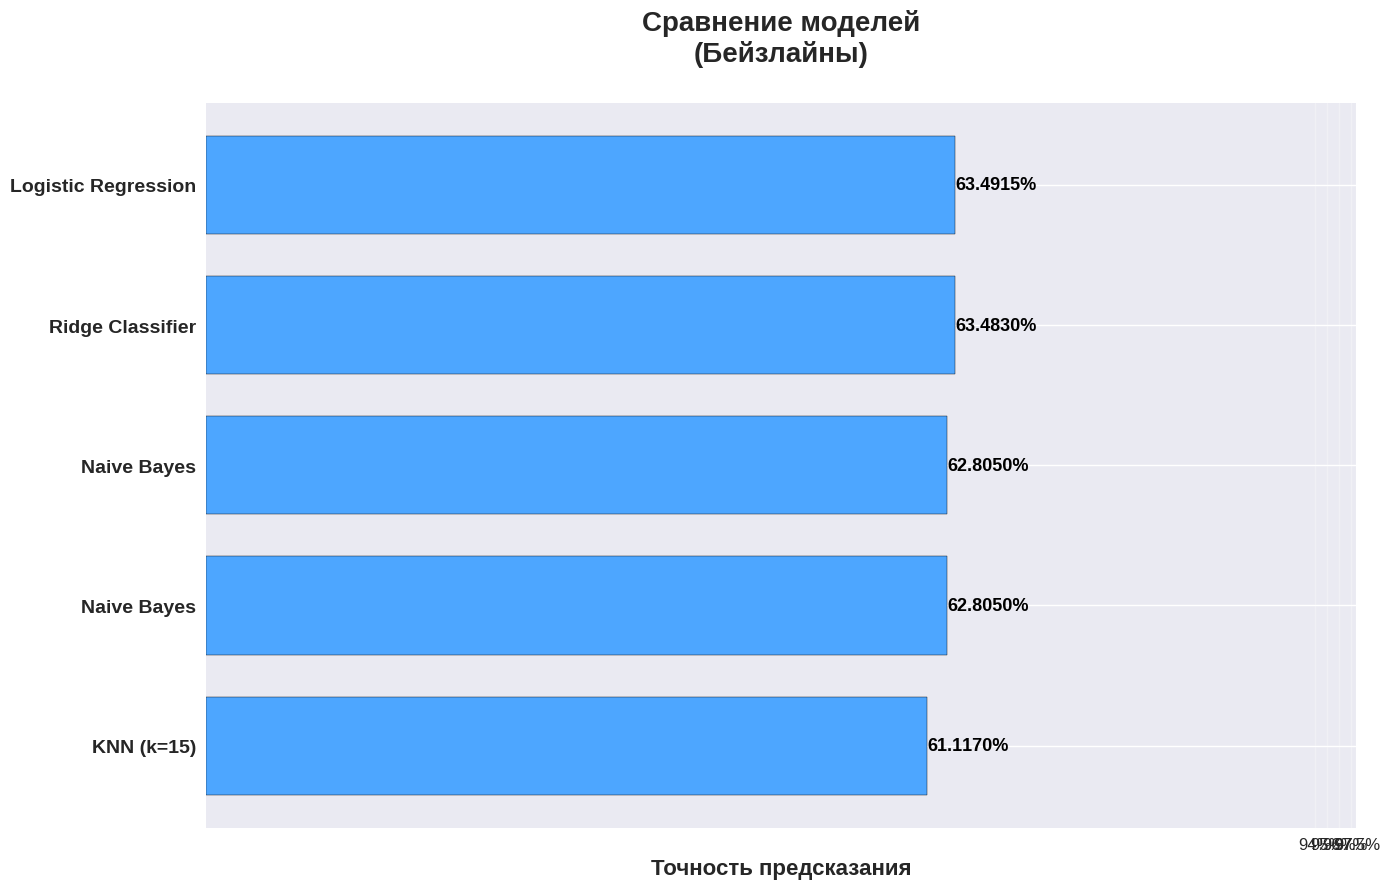

In [48]:
results = sorted(results, key=lambda x: x[1], reverse=True)
names = [x[0] for x in results]
accs  = [x[1] for x in results]
plt.figure(figsize=(14, 9))
colors = ['#ff4d4d' if acc >= 0.7 else '#4da6ff' for acc in accs]
bars = plt.barh(range(len(names)), accs, color=colors, edgecolor='black', height=0.7)
for i, (name, acc) in enumerate(results):
    if acc >= 0.975:
        bars[i].set_color('#ff1a1a')
        bars[i].set_edgecolor('#ff9900')
        bars[i].set_linewidth(3)
plt.yticks(range(len(names)), names, fontsize=14, fontweight='bold')
plt.xticks([0.94, 0.95, 0.96, 0.97, 0.975], ['94%', '95%', '96%', '97%', '97.5%'], fontsize=12)
plt.xlabel('Точность предсказания', fontsize=16, fontweight='bold')
plt.title('Сравнение моделей\n(Бейзлайны)', 
          fontsize=20, fontweight='bold', pad=30)
for i, (name, acc) in enumerate(results):
    plt.text(acc + 0.0003, i, f'{acc:.4%}', va='center', fontsize=13, fontweight='bold',
             color='black' if acc < 0.975 else 'gold')

plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### Кластеризация

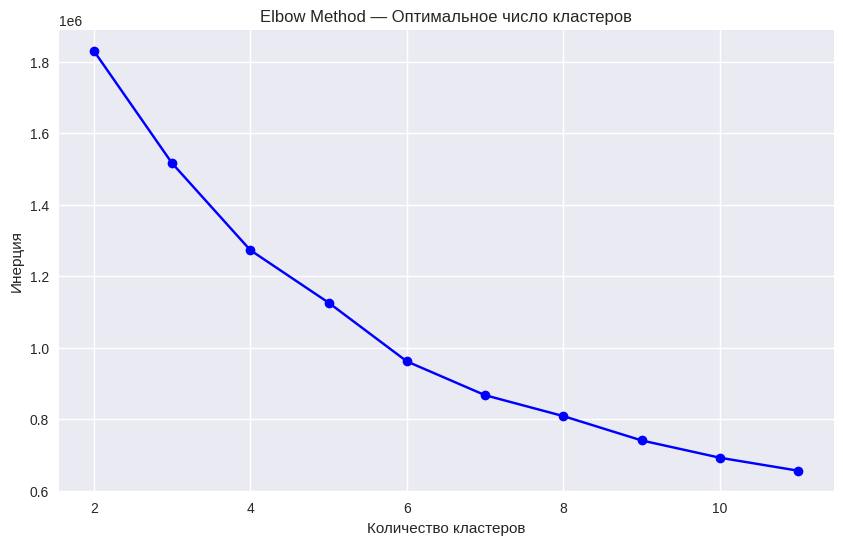

In [50]:
cluster_features = X.copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_features)
inertias = []
K = range(2, 12)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, inertias, 'bo-')
plt.title('Elbow Method — Оптимальное число кластеров')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.grid(True)
plt.show()

In [51]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
final_df['cluster'] = clusters
cluster_means = final_df.groupby('cluster')[X.columns].mean()
print("\nХАРАКТЕРИСТИКИ КЛАСТЕРОВ:")
display(cluster_means.round(3))


ХАРАКТЕРИСТИКИ КЛАСТЕРОВ:


,master_diff,meta_diff,pair_diff,contr_diff
cluster,,,,
0,0.117,0.028,1.289,2.673
1,0.165,-0.010,-0.002,-0.975
2,-0.016,-0.033,-1.129,-3.163
3,-1.219,-0.004,-0.052,-0.313
4,0.157,0.019,-0.065,1.878


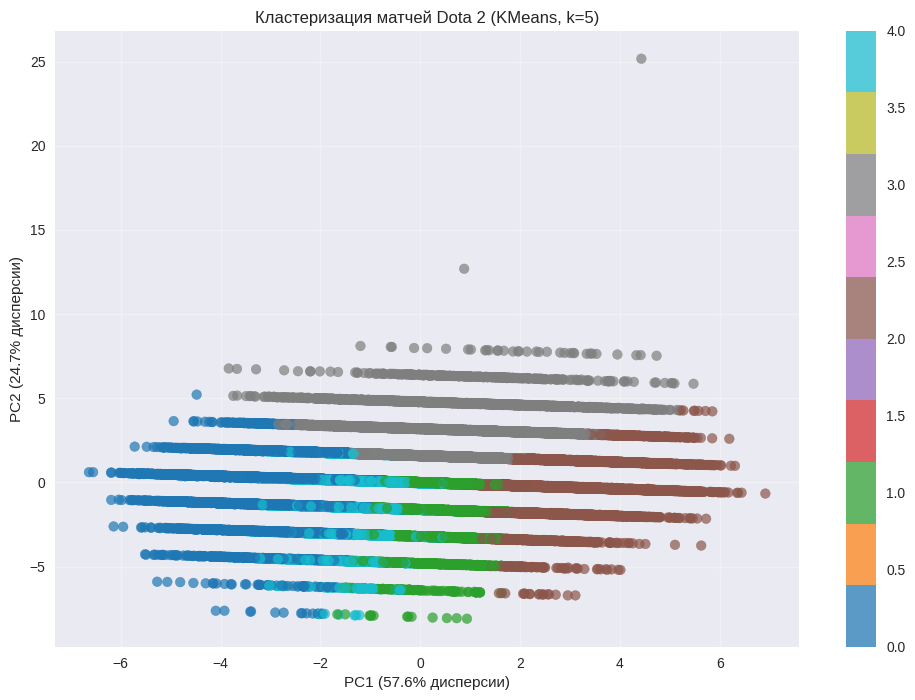

In [52]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10', alpha=0.7)
plt.title(f'Кластеризация матчей Dota 2 (KMeans, k={n_clusters})')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} дисперсии)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} дисперсии)')
plt.colorbar(scatter)
plt.grid(True, alpha=0.3)
plt.show()

In [53]:
print("\nВИНРЕЙТ ПО КЛАСТЕРАМ:")
cluster_winrate = final_df.groupby('cluster')['radiant_win'].mean().sort_values(ascending=False)
print(cluster_winrate.round(4))


ВИНРЕЙТ ПО КЛАСТЕРАМ:
cluster
0    0.6704
4    0.6346
1     0.501
2    0.3476
3     0.275
Name: radiant_win, dtype: Float64


## Леса и ансамбли

In [92]:
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    HistGradientBoostingClassifier,
    BaggingClassifier,
    AdaBoostClassifier
)
from lightgbm import LGBMClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import VotingClassifier
import joblib

results_a = []

### Desicion Tree

In [91]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
dt = DecisionTreeClassifier(
    max_depth=6,
    min_samples_leaf=50,
    random_state=42,
    ccp_alpha=0.0001 
)
dt.fit(X_train, y_train)

pred_dt = dt.predict(X_test)
acc_dt = accuracy_score(y_test, pred_dt)
results.append(("Decision Tree", acc))
results_a.append(("Decision Tree", acc))
print("Decision Tree", acc)

Decision Tree 0.6356507399517315


### Градиентный бустинг

In [90]:
hgb = HistGradientBoostingClassifier(
    max_iter=2000, learning_rate=0.05, max_depth=None, random_state=42
)
hgb.fit(X_train, y_train)
pred = hgb.predict(X_test)
acc = accuracy_score(y_test, pred)
results_a.append(('HistGBDT', acc))
results.append(('HistGBDT', acc))
print(('HistGBDT', acc))

('HistGBDT', 0.6356507399517315)


### Light GBM

In [89]:
lgbm = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.03,
    max_depth=-1,
    num_leaves=512,
    subsample=0.8,
    colsample_bytree=0.7,
    reg_alpha=0.1,
    reg_lambda=0.1,
    min_child_samples=20,
    random_state=42
)
lgbm.fit(X_train, y_train)
pred_lgbm = lgbm.predict(X_test)
acc_lgbm = accuracy_score(y_test, pred_lgbm)
results_a.append(('LightGBM', acc_lgbm))
results.append(('LightGBM', acc_lgbm))
print('LightGBM', acc_lgbm)

LightGBM 0.6350703856525093


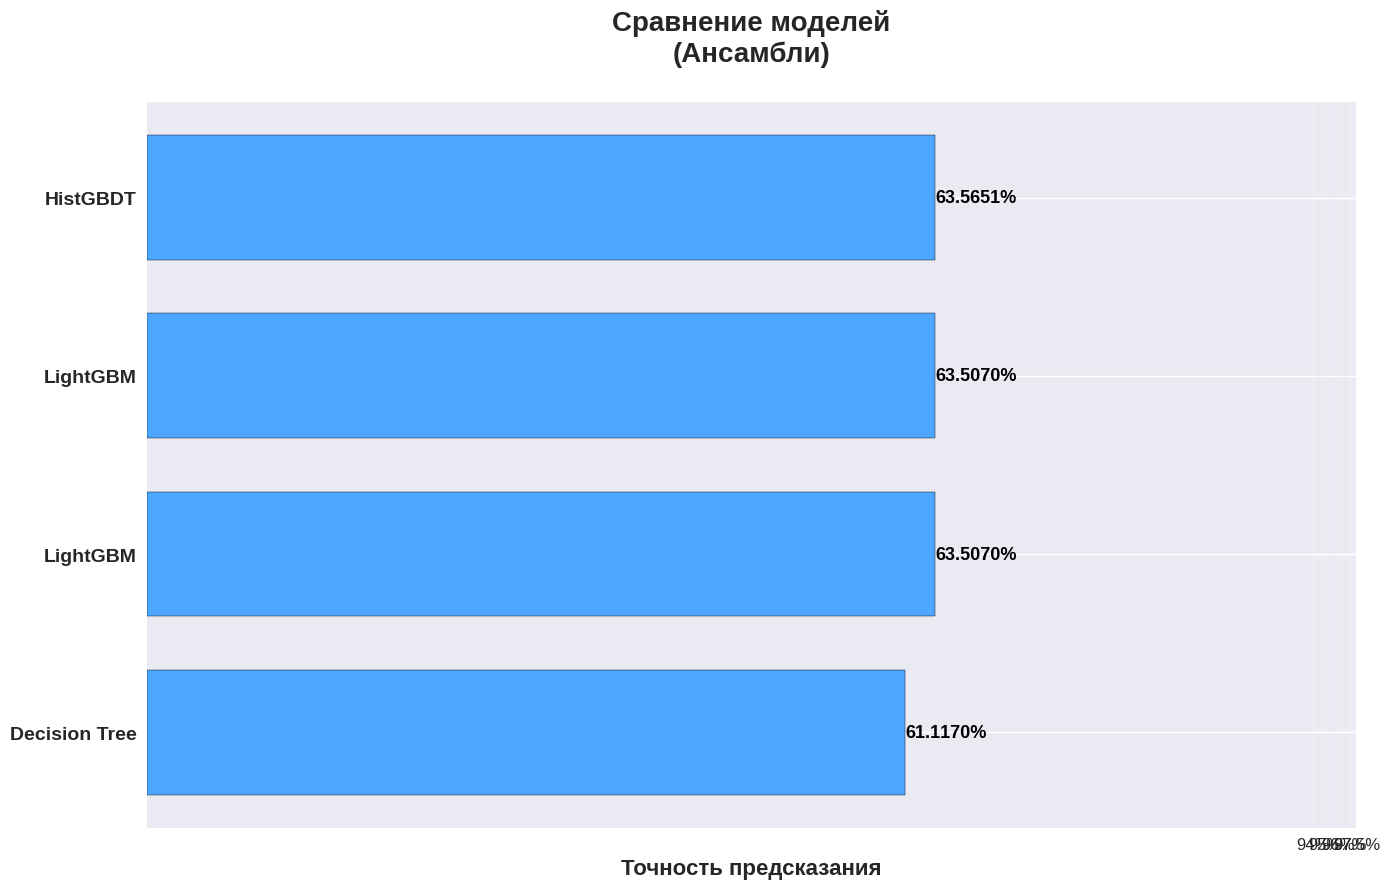

In [74]:
results = sorted(results_a, key=lambda x: x[1], reverse=True)
names = [x[0] for x in results]
accs  = [x[1] for x in results]
plt.figure(figsize=(14, 9))
colors = ['#ff4d4d' if acc >= 0.7 else '#4da6ff' for acc in accs]
bars = plt.barh(range(len(names)), accs, color=colors, edgecolor='black', height=0.7)
for i, (name, acc) in enumerate(results):
    if acc >= 0.975:
        bars[i].set_color('#ff1a1a')
        bars[i].set_edgecolor('#ff9900')
        bars[i].set_linewidth(3)
plt.yticks(range(len(names)), names, fontsize=14, fontweight='bold')
plt.xticks([0.94, 0.95, 0.96, 0.97, 0.975], ['94%', '95%', '96%', '97%', '97.5%'], fontsize=12)
plt.xlabel('Точность предсказания', fontsize=16, fontweight='bold')
plt.title('Сравнение моделей\n(Ансамбли)', 
          fontsize=20, fontweight='bold', pad=30)
for i, (name, acc) in enumerate(results):
    plt.text(acc + 0.0003, i, f'{acc:.4%}', va='center', fontsize=13, fontweight='bold',
             color='black' if acc < 0.975 else 'gold')

plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Нейронные сети

### Neural Oblivion Gradient Boosted

In [76]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [86]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(256, 128, 64), max_iter=100, early_stopping=True)
mlp.fit(X_train_scaled, y_train)
pred_mlp = mlp.predict(X_test_scaled)
acc_mlp = accuracy_score(y_test, pred_mlp)
results.append(('Neural Network', acc_mlp))
results_n.append(('Neural Network', acc_mlp))
print(('Neural Network', acc_mlp))

('Neural Network', 0.6358842971697112)


In [83]:
import torch.nn as nn
import torch.optim as optim


class TinyNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.num_classes = num_classes
        output_size = 1 if num_classes == 2 else num_classes
        
        self.network = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, output_size)
        )
    
    def forward(self, x):
        return self.network(x)

def prepare_data_tinynn(X_train, y_train, X_test, y_test):
    num_classes = len(np.unique(y_train))
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled = X_train_scaled.astype(np.float32)
    X_test_scaled = X_test_scaled.astype(np.float32)
    
    if num_classes == 2:
        y_train_array = y_train.astype(np.float32)
        y_test_array = y_test.astype(np.float32)
    else:
        y_train_array = y_train.astype(np.int64)
        y_test_array = y_test.astype(np.int64)
    
    return X_train_scaled, y_train_array, X_test_scaled, y_test_array, num_classes


X_train_prepared, y_train_prepared, X_test_prepared, y_test_prepared, num_classes = prepare_data_tinynn(
    X_train.values if hasattr(X_train, 'values') else X_train,
    y_train.values if hasattr(y_train, 'values') else y_train,
    X_test.values if hasattr(X_test, 'values') else X_test,
    y_test.values if hasattr(y_test, 'values') else y_test
)

model = TinyNN(X_train_prepared.shape[1], num_classes)
if num_classes == 2:
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)


X_train_tensor = torch.tensor(X_train_prepared)
X_test_tensor = torch.tensor(X_test_prepared)

if num_classes == 2:
    y_train_tensor = torch.tensor(y_train_prepared).float().unsqueeze(1)
else:
    y_train_tensor = torch.tensor(y_train_prepared).long()
    
batch_size = 64
n_epochs = 30

for epoch in range(n_epochs):
    model.train()
    indices = torch.randperm(X_train_tensor.size(0))
    X_shuffled = X_train_tensor[indices]
    y_shuffled = y_train_tensor[indices]
    
    epoch_loss = 0
    for i in range(0, len(X_shuffled), batch_size):
        batch_x = X_shuffled[i:i+batch_size]
        batch_y = y_shuffled[i:i+batch_size]
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        
        if num_classes == 2:
            loss = criterion(outputs, batch_y)
        else:
            loss = criterion(outputs, batch_y.squeeze())
            
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.4f}')

model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    
    if num_classes == 2:
        pred_proba = torch.sigmoid(outputs)
        pred_tiny = (pred_proba > 0.5).float().numpy().flatten()
    else:
        pred_tiny = torch.argmax(outputs, dim=1).numpy()

acc_tiny = accuracy_score(y_test_prepared, pred_tiny)
print(f'\nTiny Neural Network Accuracy: {acc_tiny:.4f}')
results.append(('Tiny Neural Network', acc_tiny))
results_n.append(('Tiny Neural Network', acc_tiny))

Epoch 5/30, Loss: 5615.4196
Epoch 10/30, Loss: 5612.8721
Epoch 15/30, Loss: 5612.5596
Epoch 20/30, Loss: 5612.4417
Epoch 25/30, Loss: 5611.8792
Epoch 30/30, Loss: 5611.6193

Tiny Neural Network Accuracy: 0.6354


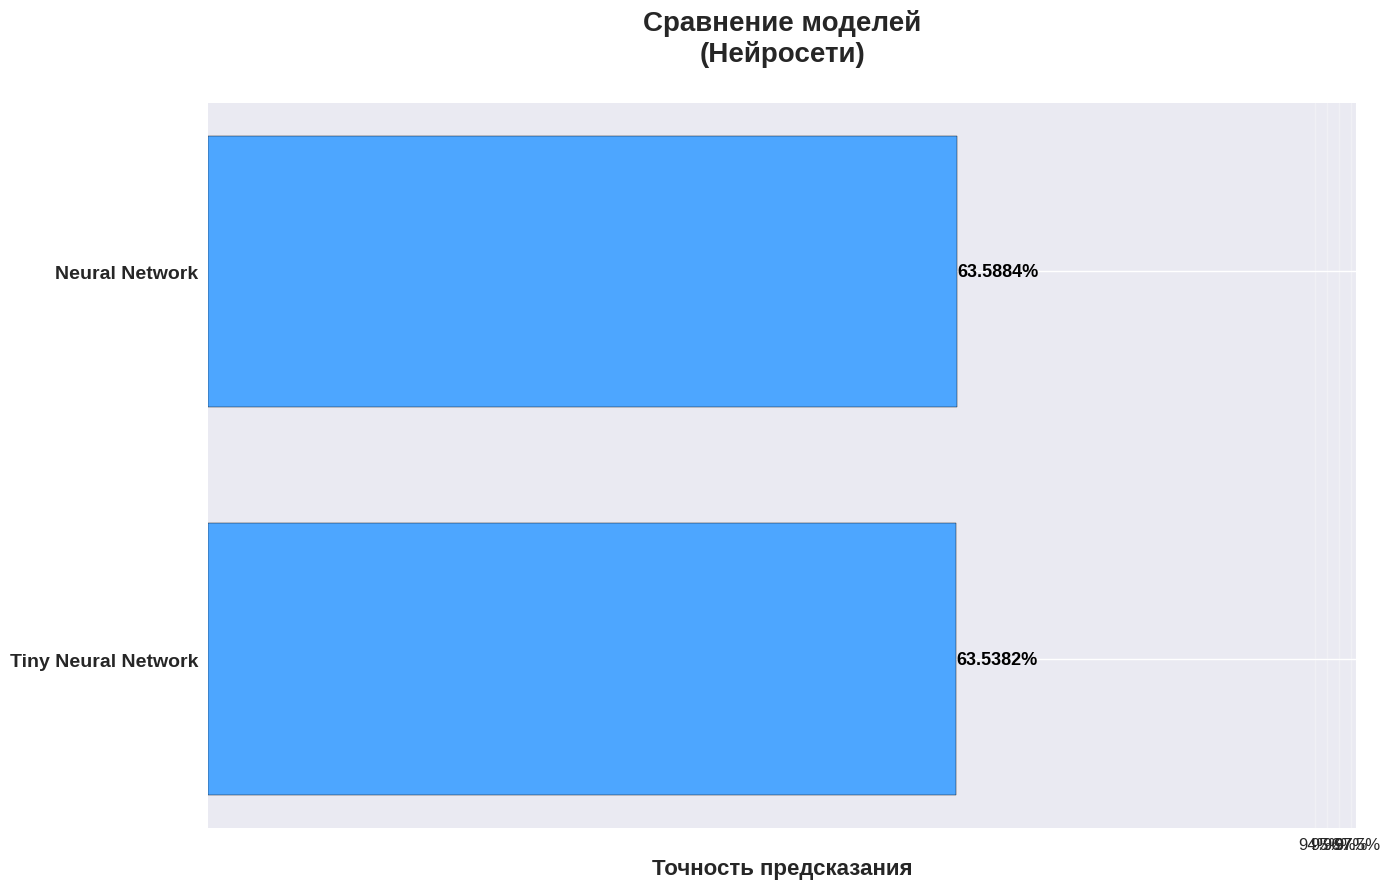

In [93]:
results = sorted(results_n, key=lambda x: x[1], reverse=True)
names = [x[0] for x in results]
accs  = [x[1] for x in results]
plt.figure(figsize=(14, 9))
colors = ['#ff4d4d' if acc >= 0.7 else '#4da6ff' for acc in accs]
bars = plt.barh(range(len(names)), accs, color=colors, edgecolor='black', height=0.7)
for i, (name, acc) in enumerate(results):
    if acc >= 0.975:
        bars[i].set_color('#ff1a1a')
        bars[i].set_edgecolor('#ff9900')
        bars[i].set_linewidth(3)
plt.yticks(range(len(names)), names, fontsize=14, fontweight='bold')
plt.xticks([0.94, 0.95, 0.96, 0.97, 0.975], ['94%', '95%', '96%', '97%', '97.5%'], fontsize=12)
plt.xlabel('Точность предсказания', fontsize=16, fontweight='bold')
plt.title('Сравнение моделей\n(Нейросети)', 
          fontsize=20, fontweight='bold', pad=30)
for i, (name, acc) in enumerate(results):
    plt.text(acc + 0.0003, i, f'{acc:.4%}', va='center', fontsize=13, fontweight='bold',
             color='black' if acc < 0.975 else 'gold')

plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()